## Etape 3 : Elaborez un modèle de clustering

Importation des librairies

In [17]:
# standard libraries import
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import itertools
import os
import time

# Machine Learning libraries import
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    davies_bouldin_score,
    make_scorer,
    pairwise_distances,
    silhouette_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

In [18]:
%matplotlib inline
# palette clusters colors
clusters_palette = {
    -1: "#808080",
    0: "#66c2a5",
    1: "#fc8d62",
    2: "#8da0cb",
    3: "#e78ac3",
    4: "#a6d854",
    5: "#ffd92f",
    6: "#e5c494",
    7: "#b3b3b3",
}

In [19]:
# create folder if not exists
if not os.path.exists("cache"):
    os.makedirs("cache")

##### Fonctions :

In [20]:
def metrics(labels, X):
    """Calculates and displays metrics :
    *number of clusters
    *number of noise points
    *silhouette score
    *Davies-Bouldin index
    """

    # number of 'noise' points
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Davies-Bouldin index
    if len(set(labels)) > 1 and len(set(labels)) < len(labels):
        davies_bouldin = davies_bouldin_score(X, labels)
    else:
        davies_bouldin = None

    print(f"Number of clusters: {n_clusters_}")
    print(f"Number of noise points: {n_noise_}")
    print(f"Silhouette score : {silhouette_avg}")
    print(f"Davies-Bouldin Index : {davies_bouldin}")


def plot_correlation_circle(pc_x, pc_y, title, x_label, y_label, 
                            loadings_df, list_names):
    """Display correlation circle from PCA"""
    
    plt.figure(figsize=(6, 6))

    # circle definition
    circle = plt.Circle((0, 0), 1, facecolor="none", 
                        edgecolor="b", linestyle="--")
    plt.gca().add_artist(circle)

    # projection vectors with names
    for i in range(len(loadings_df)):
        plt.arrow(
            0,
            0,
            loadings_df.iloc[i, pc_x],
            loadings_df.iloc[i, pc_y],
            head_width=0.05,
            head_length=0.05,
            linewidth=0.5,
            color="black",
        )
        plt.text(
            loadings_df.iloc[i, pc_x] * 1.15,
            loadings_df.iloc[i, pc_y] * 1.15,
            list_names[i],
            color="red",
            ha="center",
            va="center",
        )

    # graphic parameters
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.axhline(0, color="grey", lw=0.5)
    plt.axvline(0, color="grey", lw=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().set_aspect("equal")  # axes X et Y ont la même échelle
    plt.grid(False)

    plt.show()


def plot_dendrogram(labels, children, distances, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    n_samples = len(labels)
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([children, distances, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.show()


def RFM_graph(df, titre):
    """Display a RFM scatterplot from dataframe"""

    # aggregation per clusters
    df = (
        df.groupby("cluster")
        .agg({"frequence": "mean", "recence": "mean", "sum_payments": "mean"})
        .reset_index()
    )

    sizes = df["frequence"] * 800

    plt.figure(figsize=(10, 6))

    # scatter plot
    scatter = plt.scatter(
        df["recence"],
        df["sum_payments"],
        s=sizes,
        c=df["frequence"],
        cmap="viridis",
        alpha=0.7,
        edgecolors="w",
        linewidth=2,
    )

    # display clusters names
    for i in range(df.shape[0]):
        plt.text(
            df["recence"][i],
            df["sum_payments"][i],
            f'Cluster {df["cluster"][i]}',
            fontsize=9,
            ha="right",
            va="bottom",
        )

    # labels and title
    plt.xlabel("Recence (months since last order)")
    plt.ylabel("Monetary")
    plt.title(f"RFM Analysis for {titre} model")

    # color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label("Frequence")

    plt.grid(True)
    plt.show()

def RFM_satisfaction__graph(df, titre):
    """Display a RFM scatterplot from dataframe"""
    
    df = (
        df.groupby('cluster')
        .agg({'frequence':'mean', 
              'recence':'mean', 
              'sum_payments':'mean', 
              'mean_review_score':'mean'})
        .reset_index()
    )
    
    sizes = df['mean_review_score'] * 300

    # graph figure
    plt.figure(figsize=(10, 6))

    # scatter plot
    scatter = plt.scatter(
        df['recence'], 
        df['frequence'], 
        s=sizes, 
        c=df['mean_review_score'], 
        cmap='viridis', 
        alpha=0.7, 
        edgecolors="w", 
        linewidth=2
    )

    # cluster
    for i in range(df.shape[0]):
        plt.text(
            df['recence'][i], 
            df['frequence'][i], 
            f'Cluster {df["cluster"][i]}', 
            fontsize=9, 
            ha='right', 
            va='bottom'
        )

    # labels and title
    plt.xlabel("Recence (months since last order)")
    plt.ylabel('Frequence')
    plt.title(f"RFM Analysis with satisfaction for {titre} model")

    # color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Satisfaction')

    # point size legend
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0], [0], marker='o', color='w', label='Low Payments', 
               markerfacecolor='gray', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='High Payments', 
               markerfacecolor='gray', markersize=20)
    ]
    plt.legend(handles=handles, title='Monetary Value Scale')
    
    plt.grid(True)
    plt.show()

#####  

### Stratégie de modélisation : 

* **Répondre aux exigences d’Olist :**  (décrites ci-dessous)  
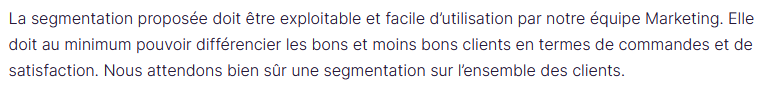  
Je commencerai par une segmentation type RFM pour ensuite ajouter la notion de "Satisfaction".  

* **Nature des features d'entrée :**
Dans le cadre d'une segmentation RFM, la nature de nos features est :
    - Récence : variable continue positive avec une échelle de temps
    - Fréquence : variable discrète qui représente des comptes d'évènements
    - Montant : variable continue positive qui représente des valeurs monétaires et possède de fortes variations
    - Satisfaction : variable discrète positive avec une faible amplitude

Afin d'optimiser l'efficacité du clustering pour les modèles choisis, une **standardisation** sera nécessaire, aisni qu'une **transformation logarithmique** pour la feature "montant" (avant la standardisation). Ceci afin de récupérer une échelle comparable en terme de **distance euclidienne**, qui est utilisée dans le KMeans et l'Agglomerative Clustering.

* **S'assurer d'une segmentation pertinente :**  
Le clustering proposé doit contenir un nombre pertinent et exploitable de segments.  
Les critères importants à vérifier sont :
    * La forme des clusters
    * La stabilité
    * La cohérence métier  

* **Etapes de modélisation :**
    1. Recherche du nombre de clusters optimal
        - Méthode du coude
        - Coefficient de silhouette
        - Index de Davies-Bouldin
    2. Modélisation RFM sur modèle `KMeans`
        - Entrainement
        - Interprétation point de vue métier
    3. Modélisation RFM sur modèle `DBSCAN` (clustering par densité)
        - Recherche hyperparamètres optimaux
        - Entrainement
        - Interprétation point de vue métier
    4. Modéliastion RFM sur modèle `Agglomerative Clustering` (clustering hiérarchique)
        - Recherche hyperparamètres optimaux
        - Entrainement
        - Interprétation point de vue métier
    5. Choix du modèle le plus pertinent point de vue métier
    6. Modélisation RFM + Satisfaction sur le modèle choisi
        - Entrainement
        - Interprétation point de vue métier

### 3.1 - Préparation des données :

**Importation du dataset :**

In [21]:
df = pd.read_csv("data/cleaned/export_all_features.csv")

---
#### 3.1.1 - Suppression de features :

Features à garder :
* `frequence`
* `recence`
* `sum_payments`

In [22]:
X = df.drop(
    columns=[
        "customer_unique_id",
        "order_received",
        "order_not_received",
        "avg_days_between_orders",
        "count_category_purchased",
        "qty_seller",
        "mean_review_score",
        "order_in_time",
        "order_late",
        "customer_city",
        "recence_date"
    ]
)

In [23]:
X.columns

Index(['frequence', 'recence', 'sum_payments'], dtype='object')

---
#### 3.1.2 - Transformation logarithmique de feature :
La distribution de la feature étant asymétrique, j'utilise la transformation logarithmique afin de retrouver une distribution "plus" normale.  
Feature concernée :
* `sum_payments`

In [28]:
# defining columns types
quantitative_features = ["frequence", "recence"]
log_transform_features = ["sum_payments"]

---
#### 3.1.3 - Création d'un pipeline de Preprocessor :

In [29]:
# standardscaler transformer
quantitative_transformer = Pipeline([("scaler", StandardScaler())])

# logarithm transformer
log_transformer = Pipeline(
    [("log_transform", FunctionTransformer(np.log1p, validate=True))]
)

# pipeline logarithm transform and standardscaler
log_and_scale_transformer = Pipeline(
    [("log_transform", log_transformer), ("scaler", StandardScaler())]
)

# full preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("quant", quantitative_transformer, quantitative_features),
        ("log_and_scale", log_and_scale_transformer, log_transform_features),
    ]
)

---
---
### 3.2 - Premier modèle de clustering : **K-means**

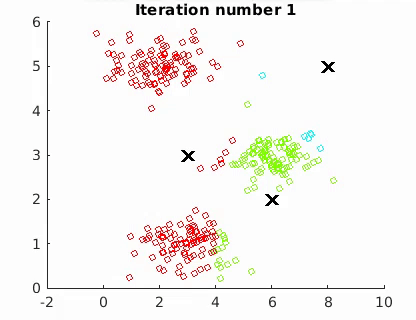

Un premier modèle est entraîné, en commençant par la recherche du nombre de cluster optimal en analysant les outils suivant :
* Graphique méthode du coude avec mesure de l'inertie
* Valeurs du coefficient de silhouette
* L'index de Davies-Bouldin

#### 3.2.1 - Création du pipeline K-means :

In [26]:
# kmeans pipeline
pipeline_kmeans = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("kmeans", 
         KMeans(n_clusters=3, init="k-means++", n_init=1, random_state=22)
        )
    ]
)

**Commentaires :**  
Utilisation des hyperparamètres `random_state` fixé à 22 et le `n_init` à 1, afin de rendre l'algorithme déterministe.

#### 3.2.2 - Boucle de recherche avec *k* entre 3 et 6 :

In [29]:
# metrics lists
inertias = []
silhouette_scores = []
db_scores = []
range_k_clusters = range(3, 7)

# loop with different cluster numbers
for k_clusters in range_k_clusters:
    pipeline_kmeans.set_params(kmeans__n_clusters=k_clusters)
    pipeline_kmeans.fit(X)

    X_transformed = pipeline_kmeans.named_steps["preprocessor"].transform(X)
    # inertias 
    inertias.append(pipeline_kmeans.named_steps["kmeans"].inertia_)

    # silhouette score
    cluster_labels = pipeline_kmeans.named_steps["kmeans"].labels_
    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Davies-Bouldin indexes
    db_score = davies_bouldin_score(X_transformed, cluster_labels)
    db_scores.append(db_score)

#### 3.2.3 - Méthode du coude :

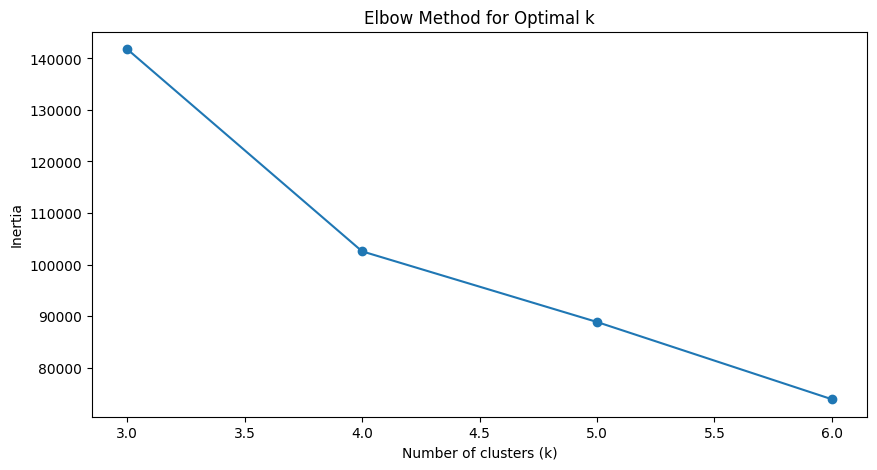

In [31]:
# elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(range_k_clusters, inertias, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

**Commentaires :**  
Léger coude à k = 4

---
#### 3.2.4 - Coefficient de silhouette :

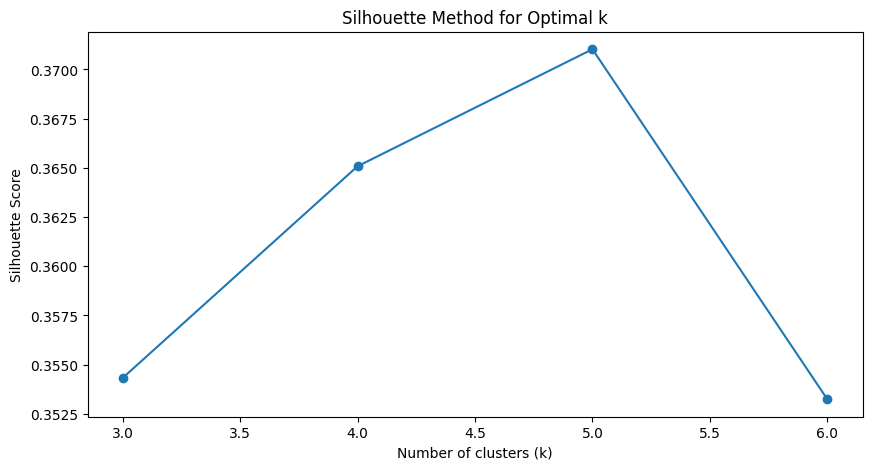

In [34]:
# silhouette score graph
plt.figure(figsize=(10, 5))
plt.plot(range_k_clusters, silhouette_scores, marker="o")
plt.title("Silhouette Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [35]:
print(silhouette_scores)

[0.3543242207098378, 0.3650805841218903, 0.3710272035688446, 0.35324045115912345]


**Commentaires :**  
Score maximum à k=5 (0.371), un score proche de 1 est idéal.

---
#### 3.2.5 - Index de Davies-Bouldin :

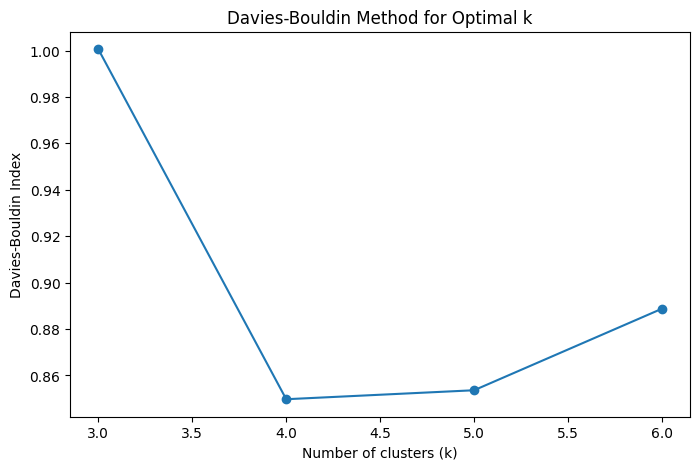

In [38]:
# Davies-Bouldin index graphic
plt.figure(figsize=(8, 5))
plt.plot(range_k_clusters, db_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Method for Optimal k")
plt.show()

In [39]:
print(db_scores)

[1.0005555609021408, 0.8497432207123727, 0.8536087893515507, 0.8887422262008161]


**Commentaires :**  
Une valeur basse est idéal.  
A k=4 la valeur est au plus bas.

---
#### 3.2.6 - Choix de la valeur de K et clustering :

La méthode du coude et l'index Davies-Boudin donne une valeur optimale de k = **4**, le coefficient de silhouette donne à k=4 un score très proche du plus fort.  
**k=4 parait être le meilleur compromis**

In [30]:
# kmeans pipeline
best_k_clusters = 4
pipeline_kmeans.set_params(kmeans__n_clusters=best_k_clusters)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('quant',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['frequence', 'recence']),
                                                 ('log_and_scale',
                                                  Pipeline(steps=[('log_transform',
                                                                   Pipeline(steps=[('log_transform',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                        validate=True))])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sum_payments'])])),
                ('kmeans', KMeans(n_clusters=4, n_init=1, random_state=22))])

In [31]:
# fit pipeline and time
start_time = time.time()
pipeline_kmeans.fit(X)
end_time = time.time()
print("Model fitting time : {:.2f} s".format(end_time - start_time))

Model fitting time : 0.16 s


In [32]:
cluster_labels = pipeline_kmeans.named_steps["kmeans"].labels_
X_transformed = pipeline_kmeans.named_steps["preprocessor"].transform(X)

In [46]:
# calculate metrics
kmeans_metrics = metrics(cluster_labels, X_transformed)
kmeans_metrics

Number of clusters: 4
Number of noise points: 0
Silhouette score : 0.3650805841218903
Davies-Bouldin Index : 0.8497432207123727


**Visualisation en 2 Composantes Principales :**

In [48]:
# pca
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_transformed)
principal_kmeans = pd.DataFrame(
    data=principal_components, 
    columns=["PC1", "PC2"]
)
principal_kmeans["cluster"] = cluster_labels

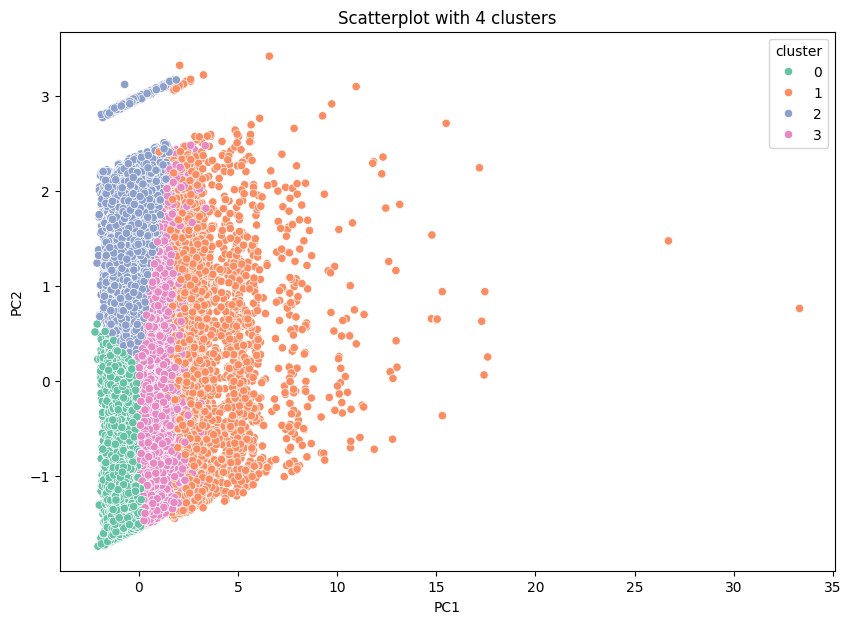

In [49]:
# scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="cluster", 
    data=principal_kmeans, 
    palette=clusters_palette
)
plt.title(f"Scatterplot with {best_k_clusters} clusters")
plt.show()

**Commentairess :**  
Les clusters sont bien définis, à part un léger mélange du cluster 3 et 1.  
Pas de fortes séparations entre les clusters mais la grande majorité des points du nuage sont regroupés.  
Cela reste une vue réduite à 2D.

**Cercle de corrélation :**

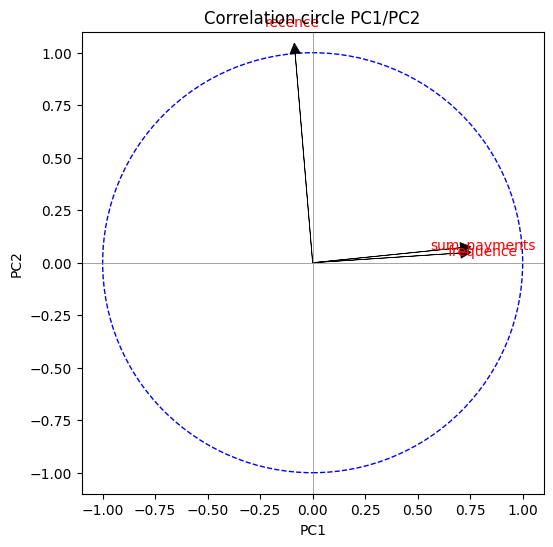

In [52]:
# pca correlation circle 
features_list_names = quantitative_features + log_transform_features
components = pca.components_

loadings_df = pd.DataFrame(
    components.T,
    columns=[f"PC{i+1}" for i in range(components.shape[0])],
    index=features_list_names,
)

plot_correlation_circle(
    0, 
    1, 
    "Correlation circle PC1/PC2", 
    "PC1", 
    "PC2", 
    loadings_df, 
    features_list_names
)

**Matrice des coefficients des Composantes Principales :**

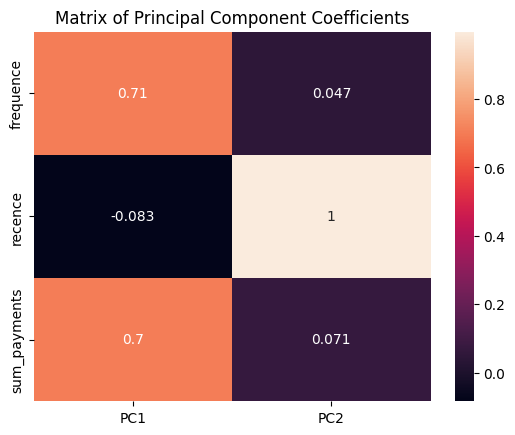

In [54]:
# pc coefficients matrix
sns.heatmap(loadings_df, annot=True)
plt.title("Matrix of Principal Component Coefficients")
plt.show()

#### 3.2.7 - Interprétation :

**Statistiques descriptives par cluster :**

In [57]:
data_kmeans = df.copy()
data_kmeans["cluster"] = cluster_labels

# descriptive statistics by cluster
data_kmeans_summary = data_kmeans.groupby("cluster").agg(
    {
        "frequence": ["count", "mean", "median", "std"],
        "recence": ["mean", "median", "std"],
        "sum_payments": ["mean", "median", "std"],
    }
)
data_kmeans_summary

frequence                               recence                       \
            count      mean median       std       mean     median       std   
cluster                                                                        
0           36049  1.000000    1.0  0.000000   4.933403   4.927727  2.804085   
1            5111  2.211309    2.0  0.634893   7.607217   7.030223  4.893797   
2           26473  1.000000    1.0  0.000000  14.086884  13.797635  2.858162   
3           25763  1.000000    1.0  0.000000   5.902761   5.716163  3.462582   

        sum_payments                      
                mean  median         std  
cluster                                   
0          66.332616   63.41   27.621684  
1         262.826136  198.59  260.966474  
2         109.409524   89.17   80.961408  
3         302.772467  200.23  308.961168

**Rappel des statitiques descriptives globales :**

In [59]:
df.describe()

,frequence,recence,sum_payments,count_category_purchased,qty_seller,mean_review_score,order_received,order_not_received,order_in_time,order_late,avg_days_between_orders
count,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000
mean,1.066288,7.941664,154.516834,1.024990,1.037261,4.104500,1.044156,0.022132,0.962097,0.082059,2.032308
std,0.312979,5.031693,206.137697,0.167607,0.214380,1.324574,0.343594,0.150636,0.433584,0.281581,19.304089
min,1.000000,0.000000,9.590000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.876478,59.407500,1.000000,1.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,7.293035,101.140000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,11.530880,171.830000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,15.000000,23.915900,7571.630000,5.000000,10.000000,5.000000,14.000000,4.000000,14.000000,4.000000,364.975683


**Commentaires :**  
La distribution des clusters parait cohérente d'un point de vue métier, le nombre de points par groupe est satisfaisant.

* **Cluster 0 : 36049 points**
    * *Frequence* : moyenne et médiane à 1, écart-tpe à 0. ==> Ces clients n'ont commandé qu'une seule fois sur le site.
    * *Recence* : moyenne à 4.9, médiane à 4.9 mois, écart-type à 2.8 mois. ==> Ces clients ont commandés en moyenne il y a 5 mois.
    * *Monetary Value* : moyenne à 66, médiane à 63 et l'écart-type à 27 Real. ==> Très faibles niveaux, très en dessous la moyenne globale.
    * *Conclusion* : ==> **Ces clients ont passés 1 commande récemment mais on dépensé très peu.**
* **Cluster 1 : 5111 points**
    * *Frequence* : moyenne à 2.2, médiane à 2, écart-type à 0.6. ==> Ces clients ont passé au moins 2 commandes sur le site.
    * *Recence* : moyenne à 7.6, médiane à 7, écart-type à 4.8 months. ==> Ces clients ont passé commande il y a environ 7/8 mois.
    * *Monetary Value* : moyenne à 262, médiane à 198,écart-type à 260. ==> Ces clients ont dépensé beaucoup, largement plus que la moyenne globale.
    * *Conclusion* : **Ces clients ont passés au moins 2 commandes, relativement récemment pour la dernière fois et ont dépensé beaucoup au total.**
* **Cluster 2 : 26473 points**
    * *Frequence* : moyenne et médiane à 1, écart-type à 0. ==> Ces clients n'ont commandé qu'une seule fois sur le site.
    * *Recence* : moyenne à 14, médiane à 13.8, écart-type à 2.8 mois. ==> Ces clients ont commandé il y a en moyenne 14 mois.
    * *Monetary Value* : moyenne à 111, médiane à 90, écart-type à 84 Real. ==> Ces clients ont dépensé moins que la moyenne globale.
    * *Conclusion* : **Ces clients ont commandé 1 fois, il y a longtemps et ont dépensé peu.**
* **Cluster 3 : 25763 points**
    * *Frequence* : moyenne et médiane à 1, écart-type à 0. ==> Ces clients n'ont commandé qu'une seule fois sur le site.
    * *Recence* : moyenne à 5.9, médiane à 5.7, écart-type à 3.5 mois. ==> Ces clients ont commandé il y a environ 6 mois.
    * *Monetary Value* : moyenne à 298, médiane à 197, écart-type à 307. ==> Ces clients ont dépensé beaucoup, 2 fois la moyenne globale.
    * *Conclusion* : **Ces clients ont commandé 1 fois, il y a peu de temps et dépensé beaucoup.**



**Représentation graphique :**

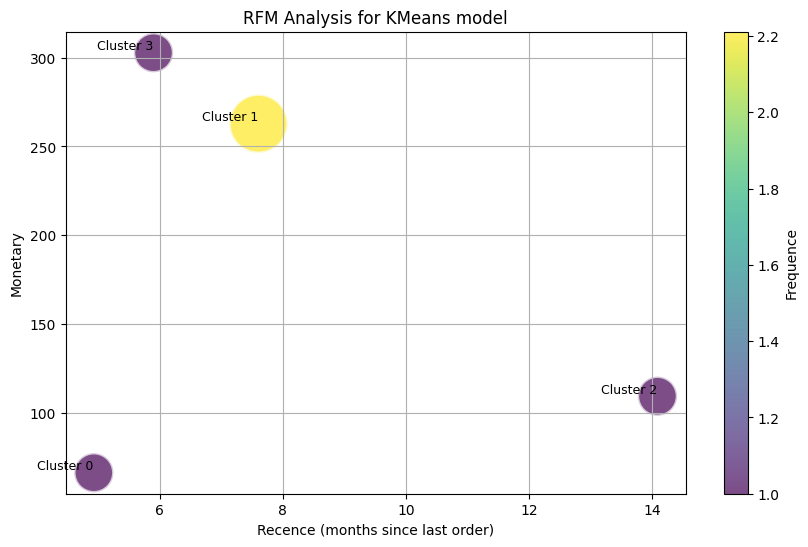

In [62]:
RFM_graph(data_kmeans, 'KMeans')

##### **Profiling des clusters KMeans :**

* Cluster 0 : "Nouveaux clients à faibles dépenses"
* Cluster 1 : "Clients potentiellement fidèles"
* Cluster 2 : "Clients inactifs/perdus"
* Cluster 3 : "Clients réguliers et dépensiers."

---
---
### 3.3 - Deuxième modèle de clustering : **DBSCAN**

Ppour ce modèle les premiers essais de valuers d'hyperparamètres donnent des valeurs aux alentours de :
* ``epsilon`` : ~1
* ``min_samples`` : < 50


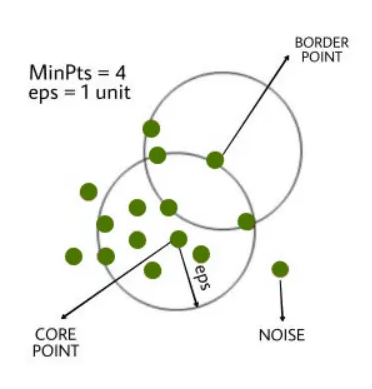

---
#### 3.3.1 - Recherche et choix des valeurs d'hyperparamètres :

Recherche des hyperparamètres optimaux avec une fonction "GridSearch" customisée, avec affichage des metrics :
* Coefficient de silhouette
* Index Davies-Bouldin
* Nombre de points en Noise

In [69]:
# hyperparameters to evaluate
epsilon = np.linspace(1, 1, num=1)
min_samples = np.arange(10, 60, 10)

combinations = list(itertools.product(epsilon, min_samples))

In [70]:
def gridsearch(combinations, X):
    """gridsearch function with custom settings"""
    
    for i, (eps, num_samples) in enumerate(combinations):
        db = DBSCAN(eps=eps, min_samples=num_samples).fit(X_transformed)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        silhouette_avg = silhouette_score(X_transformed, labels)
        if len(set(labels)) > 1 and len(set(labels)) < len(labels):
            davies_bouldin = davies_bouldin_score(X_transformed, labels)
        else:
            davies_bouldin = None
        print("iteration: ", i, 
              "ep = ", eps, 
              "min_sample = ", num_samples, 
              "number of clusters = ", n_clusters_,
              "number of noise points = ", n_noise_,
              "silhouette =", silhouette_avg,
              "IDB = ", davies_bouldin,
        )

In [71]:
gridsearch(combinations, X_transformed)

iteration:  0 ep =  1.0 min_sample =  10 number of clusters =  5 number of noise points =  35 silhouette = 0.5369509064730557 IDB =  0.8308104777862737
iteration:  1 ep =  1.0 min_sample =  20 number of clusters =  5 number of noise points =  46 silhouette = 0.5368147148564447 IDB =  0.9750235861581998
iteration:  2 ep =  1.0 min_sample =  30 number of clusters =  4 number of noise points =  75 silhouette = 0.5367181127373991 IDB =  0.8081522592768298
iteration:  3 ep =  1.0 min_sample =  40 number of clusters =  4 number of noise points =  82 silhouette = 0.5365695229546996 IDB =  0.8750327022279778
iteration:  4 ep =  1.0 min_sample =  50 number of clusters =  4 number of noise points =  103 silhouette = 0.5363350711192187 IDB =  0.9852762130281558


Dans la plage de 4 clusters, le compromis choisi est :
* `epsilon` = 1
* `min_samples` = 30

Avec **4 clusters**, nombre de points en "NOISE" = **75**, le coefficient de silhouette = **0.537** et l'index de Davies-Bouldin = **0.808**

---
#### 3.3.2 - Clustering DBSCAN :

In [74]:
# dbscan pipeline
pipeline_DBSCAN = Pipeline(
    [("preprocessor", preprocessor), ("dbscan", DBSCAN(eps=1, min_samples=30))]
)

In [75]:
# fit pipeline with time
start_time = time.time()
pipeline_DBSCAN.fit(X)
end_time = time.time()
print("Clustering took {:.2f} s".format(end_time - start_time))

Clustering took 31.44 s


In [76]:
cluster_labels = pipeline_DBSCAN.named_steps["dbscan"].labels_

In [77]:
X_transformed = pipeline_DBSCAN.named_steps["preprocessor"].transform(X)

In [78]:
# calculate dbscan metrics
dbscan_metrics = metrics(cluster_labels, X_transformed)
dbscan_metrics

Number of clusters: 4
Number of noise points: 75
Silhouette score : 0.5367181127373991
Davies-Bouldin Index : 0.8081522592768298


**Visualisation en 2 Composantes Principales :**

In [80]:
# pca
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_transformed)
principal_dbscan = pd.DataFrame(
    data=principal_components, 
    columns=["PC1", "PC2"]
)
principal_dbscan["cluster"] = cluster_labels

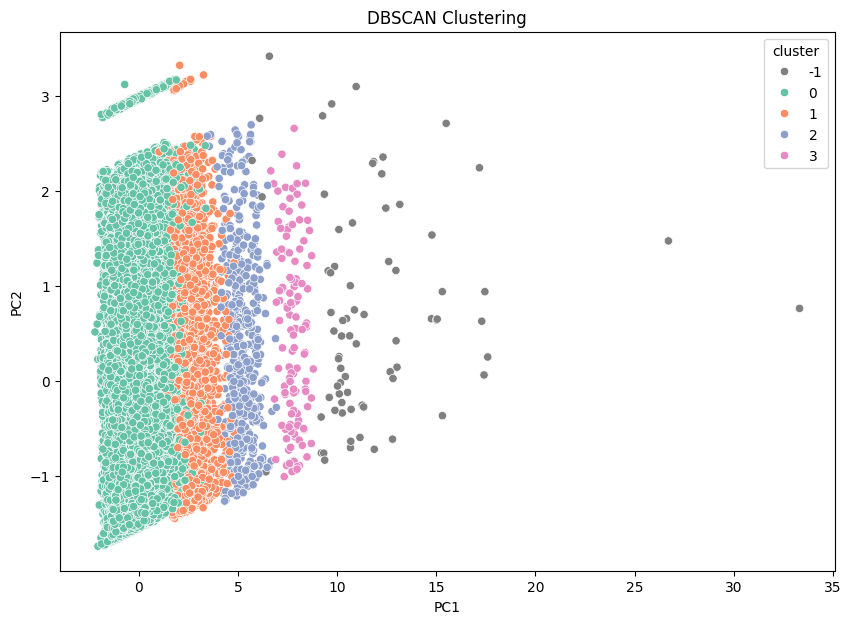

In [81]:
# scatterplot
plt.figure(figsize=(10, 7))

sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="cluster", 
    data=principal_dbscan, 
    palette=clusters_palette
)

plt.title("DBSCAN Clustering")
plt.show()

**Commentaires :**  
Les clusters sont bien différenciés.  
Les points les plus distants du nuage apparaissent en gris ==> Noise.

**Cercle de corrélation PCA :**

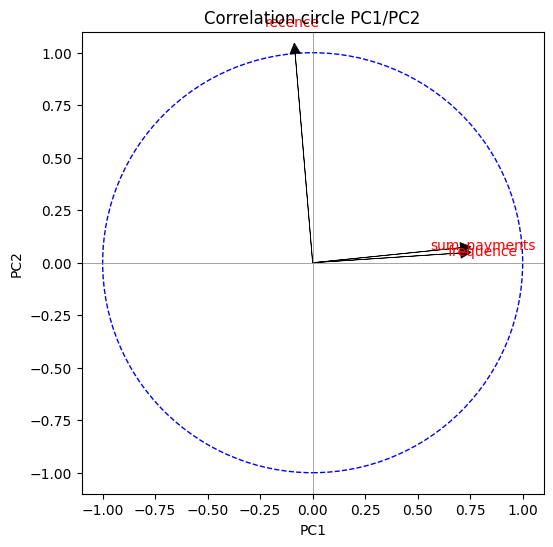

In [84]:
# pca correlation circle 
features_list_names = quantitative_features + log_transform_features
components = pca.components_

loadings_df = pd.DataFrame(
    components.T,
    columns=[f"PC{i+1}" for i in range(components.shape[0])],
    index=features_list_names,
)

plot_correlation_circle(
    0, 1, "Correlation circle PC1/PC2", "PC1", "PC2", loadings_df, 
    features_list_names
)

---
#### 3.3.3 - Interprétation :

**Statistiques descriptives des clusters :**

In [87]:
data_dbscan = df.copy()
data_dbscan["cluster"] = cluster_labels

# descriptive statistics by clusters
data_dbscan_summary = data_dbscan.groupby("cluster").agg(
    {
        "frequence": ["count", "mean", "median", "std"],
        "recence": ["mean", "median", "std"],
        "sum_payments": ["mean", "median", "std"],
    }
)

data_dbscan_summary

frequence                              recence                      \
            count      mean median       std      mean    median       std   
cluster                                                                      
-1             75  5.653333    5.0  1.759095  7.575558  6.110381  5.715122   
 0          88285  1.000000    1.0  0.000000  7.961026  7.325887  5.038907   
 1           4356  2.000000    2.0  0.000000  7.579483  7.030223  4.873980   
 2            554  3.000000    3.0  0.000000  7.842023  7.210907  4.932250   
 3            126  4.000000    4.0  0.000000  7.552458  7.621551  4.915605   

        sum_payments                        
                mean   median          std  
cluster                                     
-1        791.958000  579.170  1001.194955  
 0        148.246586   96.810   200.729658  
 1        240.201419  186.265   217.802281  
 2        326.194332  252.785   231.958817  
 3        451.416587  379.400   245.793650

**Rappel des statistiques descriptives globales :**

In [89]:
df.describe()

,frequence,recence,sum_payments,count_category_purchased,qty_seller,mean_review_score,order_received,order_not_received,order_in_time,order_late,avg_days_between_orders
count,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000
mean,1.066288,7.941664,154.516834,1.024990,1.037261,4.104500,1.044156,0.022132,0.962097,0.082059,2.032308
std,0.312979,5.031693,206.137697,0.167607,0.214380,1.324574,0.343594,0.150636,0.433584,0.281581,19.304089
min,1.000000,0.000000,9.590000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.876478,59.407500,1.000000,1.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,7.293035,101.140000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,11.530880,171.830000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,15.000000,23.915900,7571.630000,5.000000,10.000000,5.000000,14.000000,4.000000,14.000000,4.000000,364.975683


**Commentaires :**  
La distribution des cluster est plutôt hétérogène.

* **Cluster 0 : 88285 points**
    * *Frequence* : moyenne et médiane à 1, écart-type à 0. ==> Ces clients n'ont passé qu'une seule commande sur le site.
    * *Recence* : moyenne à 7.9, médiane à 7.3 mois, écart-type à 5 mois. ==> Ces clients ont commandé en moyenne il y a 7/8 mois.
    * *Monetary Value* : moyenne à 148, médiane à 96 et écart-type à 200 Real. ==> Ces clients ont dépensé comme la moyenne globale.
    * *Conclusion* : ==> **Ces clients ont réalisé 1 commande récemment et ont dépensé comme la moyenne globale.**
* **Cluster 1 : 4356 points**
    * *Frequence* : moyenne et médiane à 2, écart-type à 0. ==> Ces clients ont passé 2 commandes sur le site.
    * *Recence* : moyenne à 7.5, médiane à 7, écart-type à 4.8 mois. ==> Ces clients ont commandé en moyenne il y a 7/8 mois.
    * *Monetary Value* : moyenne à 240, médiane à 186 et écart-type à 217. ==> Ces clients ont dépensé plus que le moyenne globale.
    * *Conclusion* : **Ces clients ont réalisé 2 commandes récemment et ont dépensé plus que la moyenne globale.**
* **Cluster 2 : 554 points**
    * *Frequence* : moyenne à 3, médiane à 3, écart-type à 0. ==> Ces clients ont passé 3 commandes sur le site.
    * *Recence* : moyenne à 7.8, médiane à 7.2, écart-type à 4.9 mois. ==> Ces clients ont commandé en moyenne il y a 7/8 mois.
    * *Monetary Value* : moyenne à 326, médiane à 252, écart-type à 231 Real. ==> Ces clients ont dépensé beaucoup, plus du double de la moyenne globale.
    * *Conclusion* : **Ces clients ont réalisé 3 commandes récemment et ont dépensé plus du double de la moyenne globale.**
* **Cluster 3 : 126 points**
    * *Frequence* : moyenne à 4, médiane à 4, écart-type à 0. ==> Ces clients ont passé 4 commandes sur le site.
    * *Recence* : moyenne à 7.5, médiane à 7.6, écart-type à 4.9 months. ==> Ces clients ont commandé en moyenne il y a 7/8 mois.
    * *Monetary Value* : moyenne à 451, médiane à 379, écart-type à 245 Real. ==> Ces clients ont dépensé en moyenne 3 fois la moyenne globale.
    * *Conclusion* : **Ces clients ont réalisé 4 commandes récemment et ont dépensé le triple de la moyenne globale.**
* **NOISE : 75 points**
    * Les points en Noise représente une fréquence supérieure à 5.


La segmentation ici est réalisé sur la fréquence, les clusters sont hétérogènes.  
D'un point de vue métier, ce n'est pas pertinent et un simple filtre sur les fréquence donnerait le même résultat.

**Représentation graphique :**

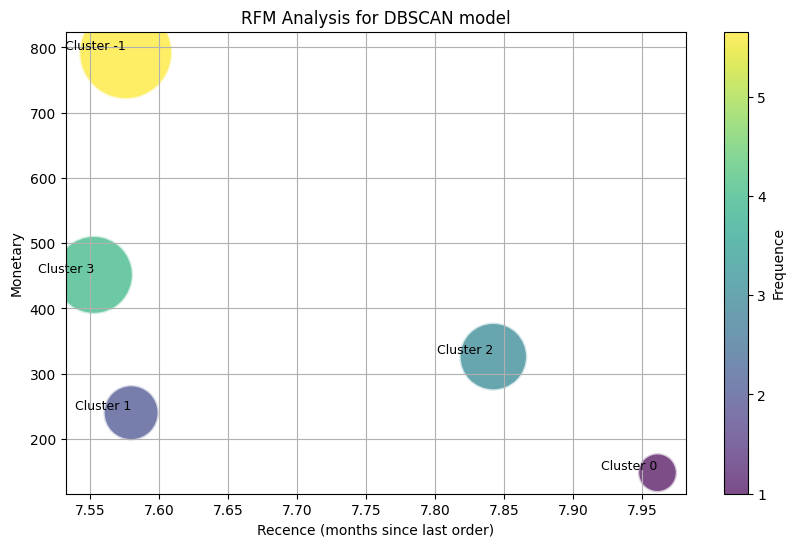

In [92]:
RFM_graph(data_dbscan, 'DBSCAN')

##### **Profiling du clustering DBSCAN :**

L'échelle de temps en abscisse est très serrée, entre 7.5 et 8 mois.

* Cluster 0 : "Clients ayant réalisé 1 commande"
* Cluster 1 : "Clients ayant réalisé 2 commandes"
* Cluster 2 : "Clients ayant réalisé 3 commandes"
* Cluster 3 : "Clients ayant réalisé 4 commandes"
* NOISE : "Clients ayant réalisé plus de 5 commandes"

---
---
### 3.4 - Troisième modèle de clustering : Agglomerative Clustering

Le modèle d'Agglomerative Clustering, avec utilisation des mesures de distances **euclidian** et l'hyperparamètres link en **single**.

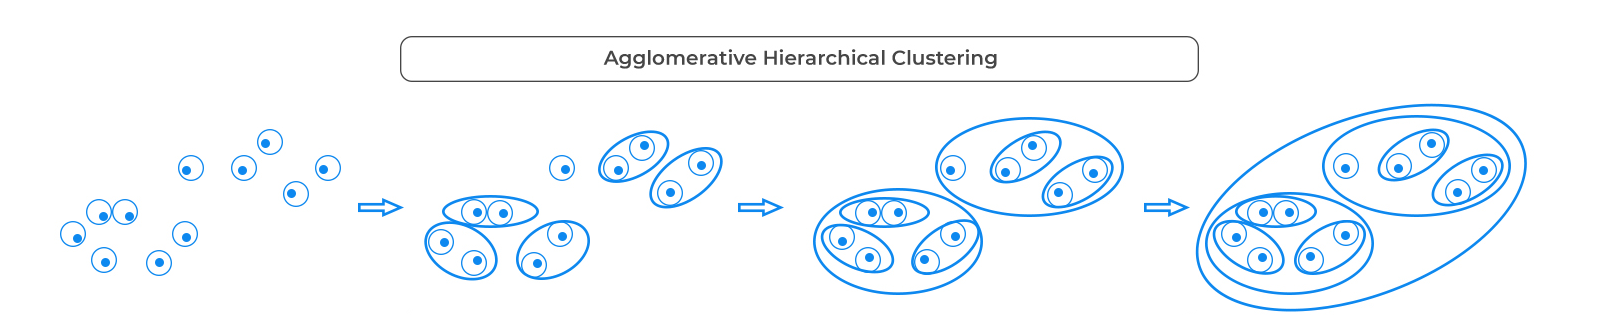

---
#### 3.4.1 - Agglomerative Clustering :

In [27]:
# agglomerativeclustering pipeline
pipeline_aggclust = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "aggclust",
            AgglomerativeClustering(
                n_clusters=4, 
                linkage="single", 
                memory="cache/", 
                compute_distances=True
            ),
        ),
    ]
)

In [29]:
# fit pipeline with time
start_time = time.time()
pipeline_aggclust.fit(X)
end_time = time.time()
print("Clustering took {:.2f} s".format(end_time - start_time))

Clustering took 0.11 s


In [31]:
cluster_labels = pipeline_aggclust.named_steps["aggclust"].labels_
X_transformed = pipeline_aggclust.named_steps["preprocessor"].transform(X)
model_children = pipeline_aggclust.named_steps["aggclust"].children_
model_distances = pipeline_aggclust.named_steps["aggclust"].distances_

In [33]:
# calculate metrics
aggclust_metrics = metrics(cluster_labels, X_transformed)
aggclust_metrics

Number of clusters: 4
Number of noise points: 0
Silhouette score : 0.9070080253898911
Davies-Bouldin Index : 0.06715168763592017


**Dendogramme :**

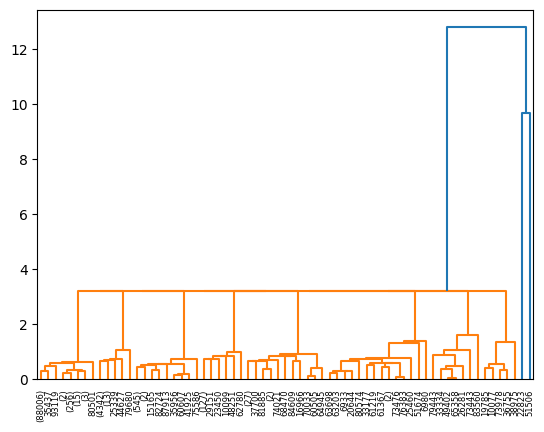

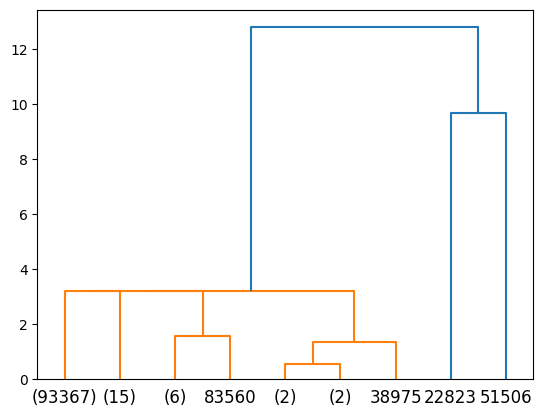

In [43]:
# dendogram
plot_dendrogram(
    cluster_labels, model_children, model_distances, truncate_mode="level", p=10
)
plot_dendrogram(
    cluster_labels, model_children, model_distances, truncate_mode="level", p=3
)

**Commentaires :**  


**Visualisation en 2 Composantes Principales :**

In [105]:
# pca
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_transformed)
principal_aggclust = pd.DataFrame(
    data=principal_components, 
    columns=["PC1", "PC2"]
)
principal_aggclust["cluster"] = cluster_labels

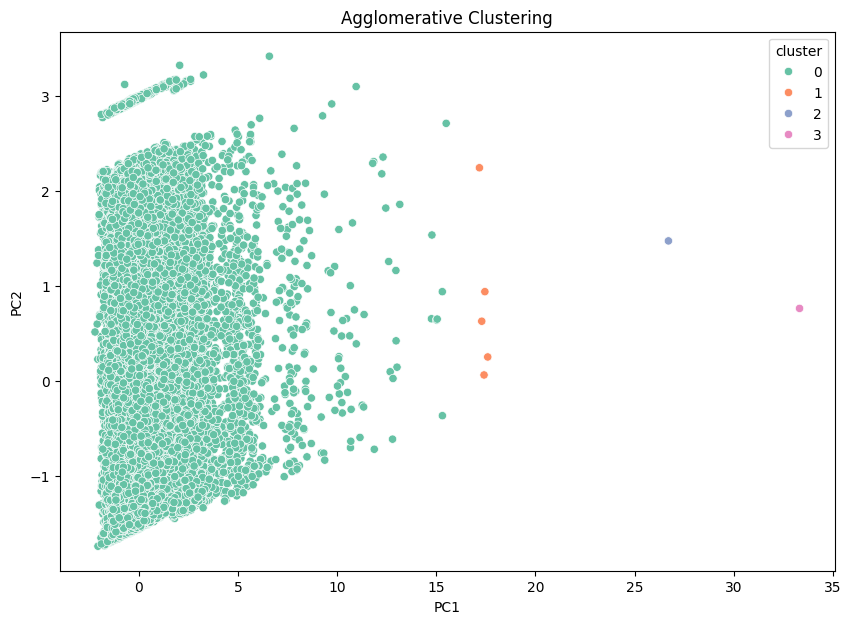

In [106]:
# scatterplt
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="cluster", 
    data=principal_aggclust, 
    palette=clusters_palette
)
plt.title("Agglomerative Clustering")
plt.show()

**Commentaires :**  
Les 4 clusters sont bien séparés, mais le nombre de points n'est pas pertinent, 2 clusters à 1 point, un troisième avec 3 points et le dernier avec tout le reste.  

**Cercle de corrélation PCA :**

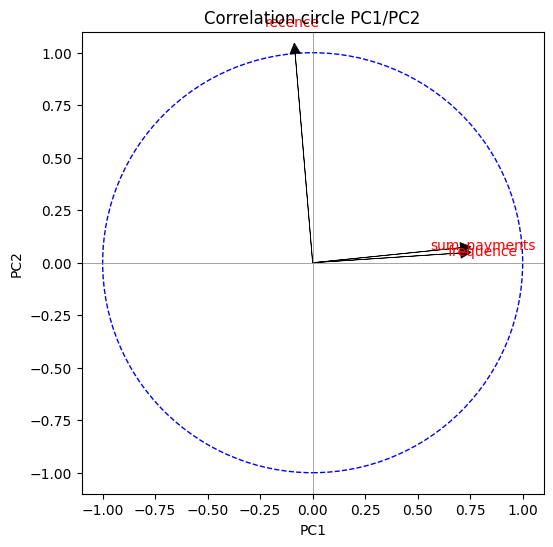

In [109]:
# pca correlation circle
features_list_names = quantitative_features + log_transform_features
components = pca.components_

loadings_df = pd.DataFrame(
    components.T,
    columns=[f"PC{i+1}" for i in range(components.shape[0])],
    index=features_list_names,
)

plot_correlation_circle(
    0, 1, "Correlation circle PC1/PC2", "PC1", "PC2", 
    loadings_df, features_list_names
)

---
#### 3.4.3 - Interprétation :

**Statistiques descriptives par clusters :**

In [112]:
data_aggclust = df.copy()
data_aggclust["cluster"] = cluster_labels

# descriptive statistics by clusters
data_aggclust_summary = data_aggclust.groupby("cluster").agg(
    {
        "frequence": ["count", "mean", "median", "std"],
        "recence": ["mean", "median", "std"],
        "sum_payments": ["mean", "median", "std"]
    }
)

data_aggclust_summary

frequence                              recence                      \
            count      mean median       std      mean    median       std   
cluster                                                                      
0           93389   1.06565    1.0  0.303364  7.941866  7.293035  5.031717   
1               5   8.00000    8.0  0.000000  6.031537  5.091984  4.377616   
2               1  12.00000   12.0       NaN  6.143233  6.143233       NaN   
3               1  15.00000   15.0       NaN  0.427070  0.427070       NaN   

        sum_payments                       
                mean   median         std  
cluster                                    
0         154.467202   101.13  206.062441  
1         763.296000   724.84  101.687820  
2        1080.100000  1080.10         NaN  
3         820.150000   820.15         NaN

**Rappel des statistiques descriptives globales :**

In [114]:
df.describe()

,frequence,recence,sum_payments,count_category_purchased,qty_seller,mean_review_score,order_received,order_not_received,order_in_time,order_late,avg_days_between_orders
count,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000
mean,1.066288,7.941664,154.516834,1.024990,1.037261,4.104500,1.044156,0.022132,0.962097,0.082059,2.032308
std,0.312979,5.031693,206.137697,0.167607,0.214380,1.324574,0.343594,0.150636,0.433584,0.281581,19.304089
min,1.000000,0.000000,9.590000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.876478,59.407500,1.000000,1.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,7.293035,101.140000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,11.530880,171.830000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,15.000000,23.915900,7571.630000,5.000000,10.000000,5.000000,14.000000,4.000000,14.000000,4.000000,364.975683


**Commentaires :**  
La distribution des clusters est très pauvre, avec le cluster 0 qui regroupe presque tous les points.


* **Cluster 0 : 93389 points**
    * *Frequence* : moyenne à 1.06, médiane à 1, écart-type à 0. ==> Ces clients n'ont passé qu'une seule commande sur le site.
    * *Recence* : moyenne à 7.9, médiane à 7.3, écart-type à 5 mois. ==> Ces clients ont passé commande en moyenne il y a 7/8 mois.
    * *Monetary Value* : moyenne à 154, médiane à 101, écart-type à 206 Real. ==> Ces clients ont dépensé comme la moyenne globale.
    * *Conclusion* : ==> **Ces clients ont passé 1 commande il y a 8 mois et ont dépensé comme la moyenne globale.**
* **Cluster 1 : 5 points**
    * *Frequence* : moyenne et médiane à 8, écart-type à 0. ==> Ces clients ont passé 8 commandes.
    * *Recence* : moyenne à 6, médiane à 5, écart-type à 4.3 mois. ==> Ces clients ont passé commande en moyenne il y a 6 mois.
    * *Monetary Value* : moyenne à 763, médiane à 724, écart-type à 101 Real. ==> Ces clients ont dépensé beaucoup, largement plus que la moyenne.
    * *Conclusion* : **Ces clients ont passé 8 commandes plutôt récemment pour la dernière et dépensé beaucoup au total.**
* **Cluster 2 : 1 point**
    * *Frequence* : moyenne à 12, médiane à 12, écart-type à 0. ==> Ce client a passé 12 commandes.
    * *Recence* : moyenne à 6.1, médiane à 6.1, écart-type à 0 mois. ==> Ce client a passé sa dernière commande il y a 6 mois.
    * *Monetary Value* : moyenne à 1080, médiane à 1080 and écart-type à 0 Real. ==> Le client a dépensé un fort montant au total.
    * *Conclusion* : **Ce client a passé 12 commandes plutôt récemment pour la dernière et dépensé le plus fort montant au total.**
* **Cluster 3 : 1 point**
    * *Frequence* : moyenne à 15, médiane à 15, écart-type à 0. ==> Ce client a passé 15 commandes.
    * *Recence* : moyenne à 0.4, médiane à 0.4, écart-type à 0 mois. ==> Ce client à passé sa dernière commande il y a 2 semaines.
    * *Monetary Value* : moyenne à 820, médiane à 820, écart-type à 0 Real. ==> Ce client a dépensé un montant conséquent.
    * *Conclusion* : **Cette personne a passé 15 commandes dont la dernière très récemment et a dépensé un montant conséquent.**


Ce modèle réalise des séparations basées sur la fréquence et le montant car ce sont les features qui apportent le plus de distance.   
D'un point de vue métier ce n'est pas pertinent.

**Représentation graphique :**

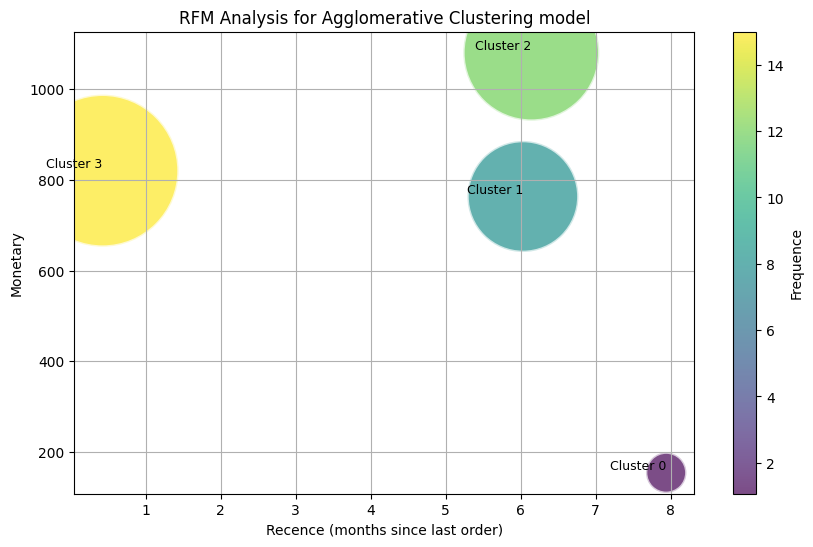

In [117]:
RFM_graph(data_aggclust, 'Agglomerative Clustering')

**Commentaires :**  
Ce graphique est trompeur, et peut induire une mauvaise interprétation :
* Les clusters 1, 2 et 3 représentes des clients avec une forte fréquence et des montants élevés mais ne représentent que 7 personnes.
* Le cluster 0 parait et est moins performant que les autres mais représente 99.9% des clients.

---
---
### 3.5 - Clustering RFM + "Satisfaction" :

Afin d'ajouter la notion de **satisfaction**, j'inclue la feature `mean_review_score` qui nous donne la note moyenne donné par les clients et reflète leur satisfaction.  
Le modèle utiliser est le **KMeans** qui fait resortir la segmentation la plus pertinente.

---
#### 3.5.1 - Préparation des données :

Récupération des données RFM avec en plus `mean_review_score`

In [123]:
df.columns

Index(['customer_unique_id', 'frequence', 'recence', 'recence_date',
       'sum_payments', 'count_category_purchased', 'qty_seller',
       'mean_review_score', 'order_received', 'order_not_received',
       'order_in_time', 'order_late', 'customer_city',
       'avg_days_between_orders'],
      dtype='object')

In [124]:
X_satisfaction = df.drop(
    columns=[
        "customer_unique_id",
        "count_category_purchased",
        "qty_seller",
        "order_received",
        "order_not_received",
        "order_in_time",
        "customer_city",
        "order_late",
        "avg_days_between_orders",
        "recence_date"
    ]
)

---
#### 3.5.2 - Transformation logarithmique de la feature :
* `sum_payments`

In [126]:
# defining columns types
quantitative_features_satisfaction = [
    "frequence", 
    "recence", 
    "mean_review_score"
]
log_transform_features = ["sum_payments"]

---
#### 3.5.3 - Entrainement du modèle KMeans :

In [128]:
# standardscaler transformer
quantitative_transformer = Pipeline([("scaler", StandardScaler())])

# logarithm transformer
log_transformer = Pipeline(
    [("log_transform", FunctionTransformer(np.log1p, validate=True))]
)

# pipeline logarithm transform and standardscaler
log_and_scale_transformer = Pipeline(
    [("log_transform", log_transformer), ("scaler", StandardScaler())]
)

# full preprocessor pipeline
preprocessor_satisfaction = ColumnTransformer(
    transformers=[
        ("quant", quantitative_transformer, quantitative_features_satisfaction),
        ("log_and_scale", log_and_scale_transformer, log_transform_features),
    ]
)

In [129]:
# kmeans pipeline
pipeline_kmeans_satisfaction = Pipeline(
    [
        ("preprocessor", preprocessor_satisfaction),
        (
            "kmeans",
            KMeans(
                n_clusters=4, 
                init="k-means++", 
                n_init=1, 
                random_state=22),
        ),
    ]
)

**Commentaires :**  
En utilisant le paramètres `random_state` fixé à 22 et `n_init` à 1, cela rend l'algorithme déterministe.

In [131]:
# fit pipeline and time
start_time = time.time()
pipeline_kmeans_satisfaction.fit(X_satisfaction)
end_time = time.time()
print("Clustering took {:.2f} s".format(end_time - start_time))

Clustering took 0.05 s


In [132]:
cluster_labels_satisfaction = pipeline_kmeans_satisfaction.named_steps[
    "kmeans"
].labels_

X_transformed_satisfaction = pipeline_kmeans_satisfaction.named_steps[
    "preprocessor_satisfaction"
].transform(X_satisfaction)

In [133]:
# calculate metrics
kmeans_metrics = metrics(cluster_labels_satisfaction, X_transformed_satisfaction)
kmeans_metrics

Number of clusters: 4
Number of noise points: 0
Silhouette score : 0.3165527487175639
Davies-Bouldin Index : 1.064531893997239


**Visualisation en 2 Composantes Principales :**

In [135]:
# pca
pca = PCA(n_components=2)
principal_components_satisfaction = pca.fit_transform(X_transformed_satisfaction)
principal_kmeans_satisfaction = pd.DataFrame(
    data=principal_components_satisfaction, columns=["PC1", "PC2"]
)
principal_kmeans_satisfaction["cluster"] = cluster_labels_satisfaction

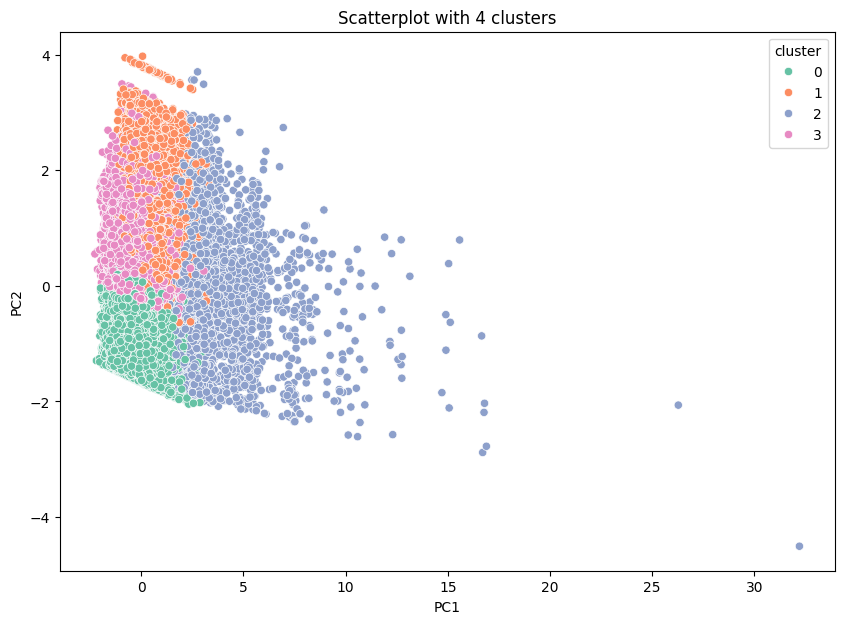

In [136]:
# scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="cluster", 
    data=principal_kmeans_satisfaction, 
    palette=clusters_palette
)
plt.title(f"Scatterplot with 4 clusters")
plt.show()

**Commentaires :**  
La différenciation des segments est plutôt claire malgré un léger mélange des clusters 1 et 3.

**Cercle de corrélation :**

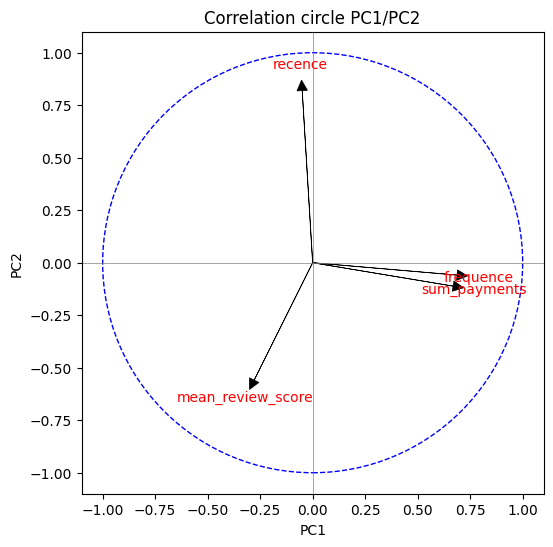

In [139]:
# pca correlation circle
features_list_names = quantitative_features_satisfaction + log_transform_features
components = pca.components_
loadings_df = pd.DataFrame(
    components.T,
    columns=[f"PC{i+1}" for i in range(components.shape[0])],
    index=features_list_names,
)
plot_correlation_circle(0, 1, "Correlation circle PC1/PC2", "PC1", "PC2", 
                        loadings_df, features_list_names)

**Matrice des coefficients des Composantes Principales :**

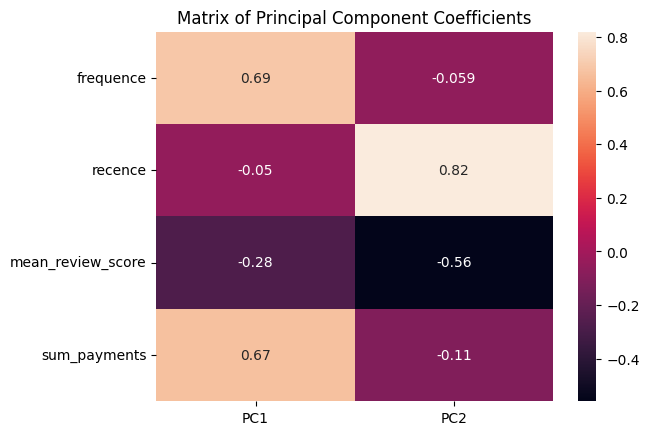

In [141]:
sns.heatmap(loadings_df, annot=True)
plt.title("Matrix of Principal Component Coefficients")
plt.show()

---
#### 3.5.4 - Interprétation :

**Statistiques descriptives par clusters :**

In [144]:
data_kmeans_satis = df.copy()
data_kmeans_satis["cluster"] = cluster_labels_satisfaction
# clustering statistic descriptive 
data_kmeans_satis_summary = data_kmeans_satis.groupby("cluster").agg(
    {
        "frequence": ["count", "mean", "median", "std"],
        "recence": ["mean", "median", "std"],
        "sum_payments": ["mean", "median", "std"],
        "mean_review_score": ["mean", "median", "std"],
    }
)
data_kmeans_satis_summary

frequence                               recence                       \
            count      mean median       std       mean     median       std   
cluster                                                                        
0           41450  1.000000    1.0  0.000000   4.132247   4.040736  2.385151   
1           15675  1.000000    1.0  0.000000   7.993430   7.293035  4.310326   
2            5111  2.211309    2.0  0.634893   7.607217   7.030223  4.893797   
3           31160  1.000000    1.0  0.000000  13.037886  12.713535  3.122434   

        sum_payments                     mean_review_score                      
                mean  median         std              mean    median       std  
cluster                                                                         
0         144.246301   96.47  193.058430          4.680048  5.000000  0.549001  
1         158.573592   99.90  215.316794          1.639872  1.000000  0.837357  
2         262.826136  198.59  260.966474          3.740733  4.333333  1.468296  
3         148.372902   95.76  202.942366          4.638383  5.000000  0.590295

**Rappel des statistiques descriptives globales :**

In [146]:
df.describe()

,frequence,recence,sum_payments,count_category_purchased,qty_seller,mean_review_score,order_received,order_not_received,order_in_time,order_late,avg_days_between_orders
count,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000
mean,1.066288,7.941664,154.516834,1.024990,1.037261,4.104500,1.044156,0.022132,0.962097,0.082059,2.032308
std,0.312979,5.031693,206.137697,0.167607,0.214380,1.324574,0.343594,0.150636,0.433584,0.281581,19.304089
min,1.000000,0.000000,9.590000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.876478,59.407500,1.000000,1.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,7.293035,101.140000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,11.530880,171.830000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,15.000000,23.915900,7571.630000,5.000000,10.000000,5.000000,14.000000,4.000000,14.000000,4.000000,364.975683


**Commentairess :**  
La distribution des clusters parait cohérente d'un point de vue métier.

* **Cluster 0 : 41450 points** 
    * *Frequence* : moyenne à 1, médiane à 1, écart-type à 0. ==> Ces clients n'ont passé qu'une seule commande sur le site.
    * *Recence* : moyenne à 4.1, médiane à 4 months, écart-type à 2.4 mois. ==> Ces clients ont passé commande en moyenne il y a 4 mois.
    * *Monetary Value* : moyenne à 144, médiane à 96, écart-type à 193 Real. ==> Ces clients ont dépensé légèrement moins que la moyenne globale.
    * *Satisfaction* : moyenne à 4.6, médiane à 5 and écart-type à 0.5 ==> Ces clients sont très satisfaits.
    * *Conclusion* : ==> **Ces clients ont passé 1 seule commande récemment et dépenséun peu moins que la moyenne globale.**
* **Cluster 1 : 15675 points**
    * *Frequence* : moyenne à 1, médiane à 1, écart-type à 0. ==> Ces clients n'ont passé qu'une seule commande sur le site.
    * *Recence* : moyenne à 8, médiane à 7.3, écart-type à 4.3 mois. ==> Ces clients ont passé commande en moyenne il y a 8 mois.
    * *Monetary Value* : moyenne à 158, médiane à 99.9, écart-type à 215 Real. ==> Ces clients ont dépensé légèrement plus que la moyenne globale.
    * *Satisfaction* : moyenne à 1.6, médiane à 1, écart-type à 0.8 ==> Ces clients ne sont pas satisfaits.
    * *Conclusion* : **Ces clients ont passé 1 commande assez récemment, ont dépensé un peu plus que la moyenne globale, mais ne sont pas satisfaits.**
* **Cluster 2 : 5111 points**
    * *Frequence* : moyenne à 2.2, médiane à 2, écart-type à 0.6. ==> Ces clients ont passé au moins 2 commandes en moyenne.
    * *Recence* : moyenne à 7.6, médiane à 7, écart-type à 4.9 mois. ==> Ces clients ont passé commande leur dernière commande en moyenne il y a 7/8 mois.
    * *Monetary Value* : moyenne à 262, médiane à 198, écart-type à 261 Real ==> Ces clients ont dépensé beaucoup.
    * *Satisfaction* : moyenne à 3.7, médiane à 4.3, écart-type à 1.4 ==> Ces clients sont moyennement satisfaits.
    * *Conclusion* : **Ces clients ont passé au moins 2 commandes il n'y a pas très longtemps, ont dépensé beaucoup et sont modérément satisfaits.**
* **Cluster 3 : 31160 points**
    * *Frequence* : moyenne et médiane à 1, écart-type à 0. ==> Ces clients n'ont passé qu'une seule commande sur le site.
    * *Recence* : moyenne à 13, médiane à 12.7, écart-type à 3.1 mois. ==> Ces clients ont passé commande il y a plus d'un an.
    * *Monetary Value* : moyenne à 148, médiane à 95, écart-type à 203 Real. ==> Ces clients ont dépensé dans la moyenne globale.
    * *Satisfaction* : moyenne à 4.6, médiane à 5, écart-type à 0.6 ==> Ces clients sont très satisfaits.
    * *Conclusion* : **Ces clients ont passé une seule commande il y a longtemps, ont dépensé dans la moyenne générale et sont très satisfaits.**


**Représentation graphique:**

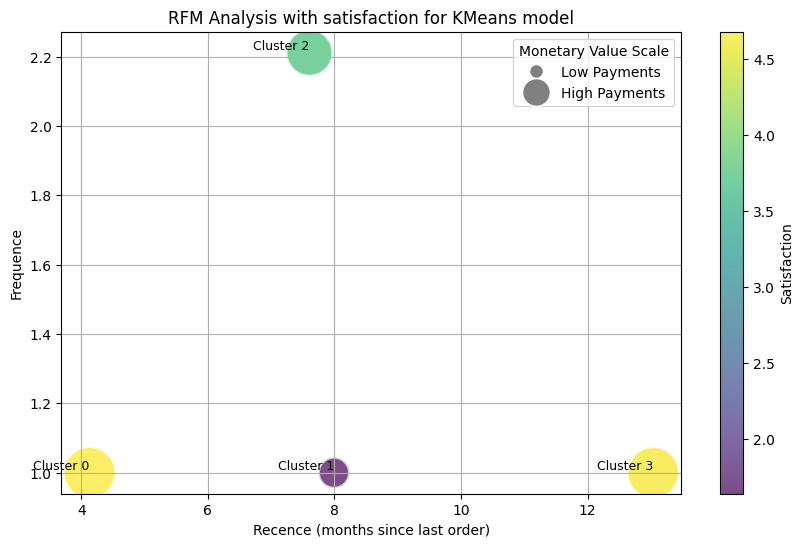

In [149]:
# display RFM representation
RFM_satisfaction__graph(data_kmeans_satis, 'KMeans')

##### **Profiling du clustering KMeans RFM + satisfaction:**

* Cluster 0 : "Nouveaux clients vraiment satisfaits"
* Cluster 1 : "Clients non fidèles et insatisfaits"
* Cluster 2 : "Clients fidèles mais modérémment satisfaits"
* Cluster 3 : "Clients inactifs/perdus mais satisfaits"

---
---
### 3.6 - Comparaison et choix des modèles :

Les odèles "DBScan" et "Agglomerative Clustering" ne sont pas adaptés à ce dataset, les modèles "KMeans" nous donnent les meilleurs résultats.  
Les 2 modèles KMeans vont être comparés.

---
#### 3.6.1 - Comparaison des modèles KMeans :

* **Segmentation RFM par KMeans :** 

In [155]:
data_kmeans_summary

frequence                               recence                       \
            count      mean median       std       mean     median       std   
cluster                                                                        
0           36049  1.000000    1.0  0.000000   4.933403   4.927727  2.804085   
1            5111  2.211309    2.0  0.634893   7.607217   7.030223  4.893797   
2           26473  1.000000    1.0  0.000000  14.086884  13.797635  2.858162   
3           25763  1.000000    1.0  0.000000   5.902761   5.716163  3.462582   

        sum_payments                      
                mean  median         std  
cluster                                   
0          66.332616   63.41   27.621684  
1         262.826136  198.59  260.966474  
2         109.409524   89.17   80.961408  
3         302.772467  200.23  308.961168

* Cluster 0 : "Nouveaux clients à faibles dépenses"
* Cluster 1 : "Clients potentiellement fidèles"
* Cluster 2 : "Clients inactifs/perdus"
* Cluster 3 : "Clients réguliers et dépensiers."

* **Segmentation RFM + Satisfaction par KMeans :**

In [158]:
data_kmeans_satis_summary

frequence                               recence                       \
            count      mean median       std       mean     median       std   
cluster                                                                        
0           41450  1.000000    1.0  0.000000   4.132247   4.040736  2.385151   
1           15675  1.000000    1.0  0.000000   7.993430   7.293035  4.310326   
2            5111  2.211309    2.0  0.634893   7.607217   7.030223  4.893797   
3           31160  1.000000    1.0  0.000000  13.037886  12.713535  3.122434   

        sum_payments                     mean_review_score                      
                mean  median         std              mean    median       std  
cluster                                                                         
0         144.246301   96.47  193.058430          4.680048  5.000000  0.549001  
1         158.573592   99.90  215.316794          1.639872  1.000000  0.837357  
2         262.826136  198.59  260.966474          3.740733  4.333333  1.468296  
3         148.372902   95.76  202.942366          4.638383  5.000000  0.590295

* Cluster 0 : "Nouveaux clients vraiment satisfaits"
* Cluster 1 : "Clients non fidèles et insatisfaits"
* Cluster 2 : "Clients fidèles mais modérémment satisfaits"
* Cluster 3 : "Clients inactifs/perdus mais satisfaits"

---
#### 3.6.2 - Selection de l'algorithme :

Les deux segmentations sont proches, mais l'ajout de la notion de "satisfaction" apporte une approche pertinente d'un point de vue métier et conforme aux exigences d'Olist.
* Modèle sélectionné : **KMeans RFM + Satisfaction classification**

---
#### 3.6.3 - Classe de clustering pour Olist:
Permet de réaliser un clustering avec un nouveau dataframe mis à jour.

* Exécution de la classe afin de réaliser le clustering par la commande :  
`clustering = OlistClustering(df)` avec df : le dataframe client

* Utilisation des méthodes :
    * `clustering.get_labels()` : permet de récupérer les labels
    * `clustering.metrics()` : permet de calculer et afficher les metrics "silhouette score" et "Index de Davies-Bouldin"
    * `clustering.plot_2D()` : affiche un graphique 2D des clusters après une PCA
    * `clustering.plot_correlation_circle()` : affiche le cercle de corrélation de la PCA
    * `clustering.principal_component_coefficients_matrix` : affiche la matrice des coefficients des composantes principales
    * `clustering.summary_clustering()` : affiche un dataframe contenant les statistiques descriptives par cluster
    * `clustering.interpretation_graph()` : affiche un graphique Scatterplot qui permet l'interpréation RFM + satisfaction

##### Code de la classe `OlistClustering` :

In [5]:
# Machine Learning libraries import
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler


# clustering class
class OlistClustering:
    """
    class is used to perform KMeans clustering on customer data from a dataframe

    Attributes:
    -df: pandas.Dataframe 
        customer dataframe
    -cluster_labels: nm.ndarray
        labels after clustering
    -X_transformed: np.ndarray
        features after preprocessing
    -pipeline: skLearn.Pipeline
        KMeans pipeline algorithm

    Methods :
    -metrics(): calculate and display metrics
    -plot_2D(): display scatterplot after 2D PCA transform
    -plot_correlation_circle(): display PCA correlation circle
    -principal_component_coefficients_matrix(): display matrix of principal component coefficients
    -summary_clustering(): display clusters descriptive statistics
    -interpretation_graph(): display interpretation clusters scatterplot
    """

    # initialisation
    def __init__(self, df):
        self.df = df
        self.cluster_labels = None
        self.X_transformed = None
        self.pipeline = None
        self.clusters_palette = {
            -1: "#808080",
            0: "#66c2a5",
            1: "#fc8d62",
            2: "#8da0cb",
            3: "#e78ac3",
        }
        self.prepare_pipeline()

    # pipeline preparation and execution
    def prepare_pipeline(self):
        """kmeans algorithm pipeline preparation and execution"""
        X = self.df[["frequence", 
                     "recence", 
                     "mean_review_score", 
                     "sum_payments"
                    ]]

        quantitative_features = ["frequence", "recence", "mean_review_score"]
        log_transform_features = ["sum_payments"]

        quantitative_transformer = Pipeline([("scaler", StandardScaler())])

        log_transformer = Pipeline([("log_transform", 
                                     FunctionTransformer(
                                         np.log1p, validate=True)
                                    )])

        log_and_scale_transformer = Pipeline(
            [("log_transform", log_transformer), ("scaler", StandardScaler())]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("quant", quantitative_transformer, quantitative_features),
                (
                    "log_and_scale", 
                    log_and_scale_transformer, 
                    log_transform_features
                ),
            ]
        )

        self.pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                (
                    "kmeans",
                    KMeans(
                        n_clusters=4, 
                        init="k-means++", 
                        n_init=1, 
                        random_state=22
                    ),
                ),
            ]
        )

        # fit the pipeline
        start_time = time.time()
        self.pipeline.fit(X)
        end_time = time.time()
        print("Clustering took {:.2f} s".format(end_time - start_time))

        self.cluster_labels = self.pipeline.named_steps["kmeans"].labels_
        self.X_transformed = self.pipeline.named_steps["preprocessor"].transform(
            X
        )

    # retrieve labels
    def get_labels(self):
        """returns the cluster labels"""
        if self.cluster_labels is None:
            print("Pipeline has not been executed yet.")
            return None
        return self.cluster_labels

    # 
    def metrics(self):
        """calculates and displays metrics"""
        if self.cluster_labels is None or self.X_transformed is None:
            print("Pipeline has not been executed yet.")
            return

        labels = self.cluster_labels
        X = self.X_transformed
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        silhouette_avg = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels) if len(
            set(labels)) > 1 else None

        print(f"Number of clusters: {n_clusters_}")
        print(f"Number of noise points: {n_noise_}")
        print(f"Silhouette score : {silhouette_avg}")
        print(f"Davies-Bouldin Index : {davies_bouldin}")

    def plot_2D(self):
        """plots a 2D PCA scatterplot of the clusters"""
        if self.X_transformed is None:
            print("Pipeline has not been executed yet.")
            return

        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(self.X_transformed)
        principal_kmeans = pd.DataFrame(
            data=principal_components, 
            columns=["PC1", "PC2"]
        )
        principal_kmeans["cluster"] = self.cluster_labels

        plt.figure(figsize=(10, 7))
        sns.scatterplot(
            x="PC1", 
            y="PC2", 
            hue="cluster", 
            data=principal_kmeans, 
            palette=self.clusters_palette
        )
        plt.title(f"Scatterplot with 4 clusters")
        plt.show()

    def plot_correlation_circle(self):
        """plots a correlation circle for PCA interpretation"""
        if self.X_transformed is None:
            print("Pipeline has not been executed yet.")
            return

        pca = PCA(n_components=2)
        components = pca.fit(self.X_transformed).components_

        features_list_names = [
            "frequence", 
            "recence", 
            "mean_review_score", "sum_payments"
        ]
        loadings_df = pd.DataFrame(
            components.T, 
            columns=[f"PC{i+1}" for i in range(components.shape[0])], 
            index=features_list_names
        )

        def plot_circle(pc_x, pc_y, title, x_label, y_label):
            """display correlation circle of PCA"""
            plt.figure(figsize=(6, 6))
            circle = plt.Circle((0, 0), 
                                1, 
                                facecolor="none", 
                                edgecolor="b", 
                                linestyle="--"
                               )
            plt.gca().add_artist(circle)

            for i in range(len(loadings_df)):
                plt.arrow(0, 
                          0, 
                          loadings_df.iloc[i, pc_x], 
                          loadings_df.iloc[i, pc_y], 
                          head_width=0.05, head_length=0.05, 
                          linewidth=0.5, color="black"
                         )
                plt.text(loadings_df.iloc[i, pc_x] * 1.15, 
                         loadings_df.iloc[i, pc_y] * 1.15, 
                         features_list_names[i], 
                         color="red", 
                         ha="center", 
                         va="center"
                        )

            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
            plt.axhline(0, color="grey", lw=0.5)
            plt.axvline(0, color="grey", lw=0.5)
            plt.title(title)
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.grid(False)
            plt.show()

        plot_circle(0, 1, "Correlation circle PC1/PC2", "PC1", "PC2")

    def principal_component_coefficients_matrix(self):
        """display the matrix of principalcomponent coefficients"""
        if self.X_transformed is None:
            print("Pipeline has not been executed yet.")
            return

        pca = PCA(n_components=2)
        components = pca.fit(self.X_transformed).components_

        features_list_names = [
            "frequence", 
            "recence", 
            "mean_review_score", "sum_payments"
        ]
        loadings_df = pd.DataFrame(
            components.T, 
            columns=[f"PC{i+1}" for i in range(components.shape[0])], 
            index=features_list_names
        )
        sns.heatmap(loadings_df, annot=True)
        plt.title("Principal Component Coefficients Matrix")
        plt.show()

    def summary_clustering(self):
        """display summary statistics for each cluster"""
        if self.cluster_labels is None:
            print("Pipeline has not been executed yet.")
            return
        data_kmeans = self.df.copy()
        data_kmeans["cluster"] = self.cluster_labels
        summary = data_kmeans.groupby("cluster").agg(
            {
                "frequence": ["count", "mean", "median", "std"],
                "recence": ["mean", "median", "std"],
                "sum_payments": ["mean", "median", "std"],
                "mean_review_score": ["mean", "median", "std"],
            }
        )
        print("Descriptive Statistics of Clusters Summary :")
        display(summary)

    def interpretation_graph(self):
        """display clusters interpretation scatterplot"""
        if self.cluster_labels is None:
            print("Pipeline has not been executed yet.")
            return
        data_kmeans = self.df.copy()
        data_kmeans["cluster"] = self.cluster_labels
        df = (
            data_kmeans.groupby('cluster')
            .agg({'frequence':'mean', 
                  'recence':'mean', 
                  'sum_payments':'mean', 
                  'mean_review_score':'mean'})
            .reset_index()
        )
    
        sizes = df['mean_review_score'] * 300

        # graph figure
        plt.figure(figsize=(10, 6))

        # scatter plot
        scatter = plt.scatter(
            df['recence'], 
            df['frequence'], 
            s=sizes, 
            c=df['mean_review_score'], 
            cmap='viridis', 
            alpha=0.7, 
            edgecolors="w", 
            linewidth=2
        )

        # cluster
        for i in range(df.shape[0]):
            plt.text(
                df['recence'][i], 
                df['frequence'][i], 
                f'Cluster {df["cluster"][i]}', 
                fontsize=9, 
                ha='right', 
                va='bottom'
            )

        # labels and title
        plt.xlabel("Recence (months since last order)")
        plt.ylabel('Frequence')
        plt.title(f"RFM Analysis with satisfaction for 'KMeans' model")

        # color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Satisfaction')

        # point size legend
        from matplotlib.lines import Line2D
        handles = [
            Line2D([0], [0], marker='o', color='w', label='Low Payments', 
                   markerfacecolor='gray', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='High Payments', 
                   markerfacecolor='gray', markersize=20)
        ]
        plt.legend(handles=handles, title='Monetary Value Scale')
    
        plt.grid(True)
        plt.show()
    

---
#### 3.6.4 - Export du dataset avec les labels

In [163]:
data_kmeans_satis.to_csv('data/cleaned/final_dataset_labels.csv', index=False)

---
---
---

# Autres essais réalisés :

In [13]:
%matplotlib inline
# sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {"alpha": 0.30, "s": 20, "linewidths": 0}

In [33]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    unique_labels = np.unique(labels)

    # Créer une palette avec suffisamment de couleurs
    n_clusters = len(unique_labels)
    palette = sns.color_palette("deep", n_clusters)
    color_mapping = {
        label: palette[i] if label != -1 else (0.0, 0.0, 0.0)
        for i, label in enumerate(unique_labels)
    }

    # Assigner les couleurs en fonction des labels
    colors = [
        color_mapping[label] if label >= 0 else (0.0, 0.0, 0.0) for label in labels
    ]

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data)

    # Ajustement du ratio de la figure
    plt.figure(figsize=(12, 6))  # Ajuster le ratio de la figure

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title("Clusters found by {}".format(str(algorithm.__name__)), fontsize=20)
    plt.text(
        30, 2.2, "Clustering took {:.2f} s".format(end_time - start_time), fontsize=12
    )

    # Création des handles pour la légende
    handles = []
    for label, color in color_mapping.items():
        if label == -1:
            label_name = "Noise"
            color = (0.0, 0.0, 0.0)  # Forcer la couleur noire pour le bruit
        else:
            label_name = f"Cluster {label}"
        handles.append(
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label=label_name,
                markerfacecolor=color,
                markersize=6,
            )
        )

    # Ajout de la légende au graphique avec ajustements
    plt.legend(
        handles=handles,
        title="Clusters",
        fontsize="x-small",
        title_fontsize="small",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        markerscale=0.8,
        borderaxespad=0.0,
        frameon=False,
    )

    plt.subplots_adjust(right=0.90)
    # compte le nombre de points 'noise'
    n_noise_ = list(labels).count(-1)
    # calcul du coefficient de silhouette
    silhouette_avg = silhouette_score(X_transformed, labels)
    # calcul de l'index de Davies-Bouldin
    if len(set(labels)) > 1 and len(set(labels)) < len(labels):
        davies_bouldin = davies_bouldin_score(X_transformed, labels)
    else:
        davies_bouldin = None
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise_}")
    print(f"Le coefficient de silhouette : {silhouette_avg}")
    print(f"L'index de Davies-Bouldin : {davies_bouldin}")

In [34]:
X_transformed = pipeline_kmeans.named_steps["preprocessor"].transform(X)

Number of clusters: 4
Number of noise points: 200
Le coefficient de silhouette : 0.5364671549708201
L'index de Davies-Bouldin : 0.7630983925399876


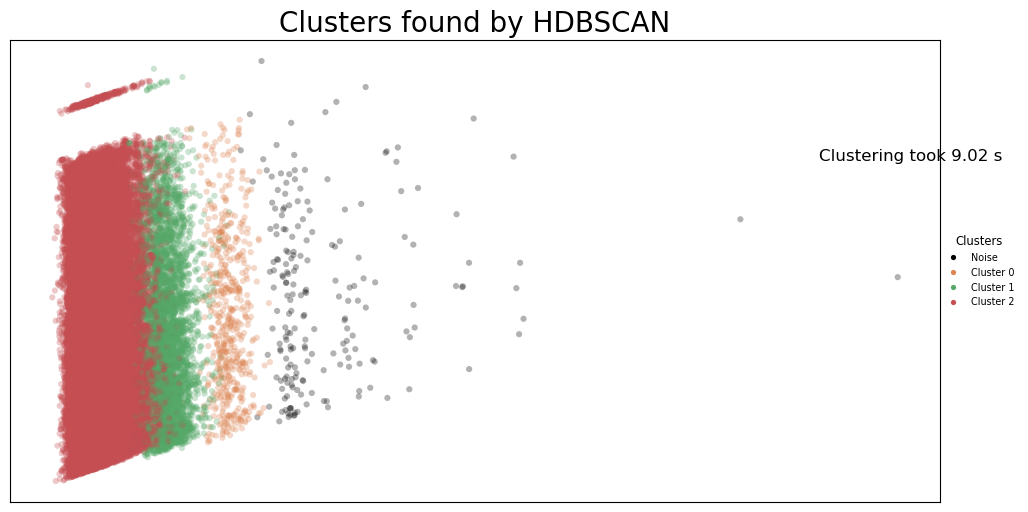

In [35]:
import hdbscan

plot_clusters(
    X_transformed,
    hdbscan.HDBSCAN,
    (),
    {
        "cluster_selection_epsilon": 1,
        "min_cluster_size": 200,
        "algorithm": "best",
        "alpha": 1.0,
        "approx_min_span_tree": True,
        "gen_min_span_tree": False,
        "leaf_size": 40,
        "metric": "euclidean",
    },
)

Number of clusters: 7
Number of noise points: 875
Le coefficient de silhouette : 0.4534654518727525
L'index de Davies-Bouldin : 1.3572980245450375


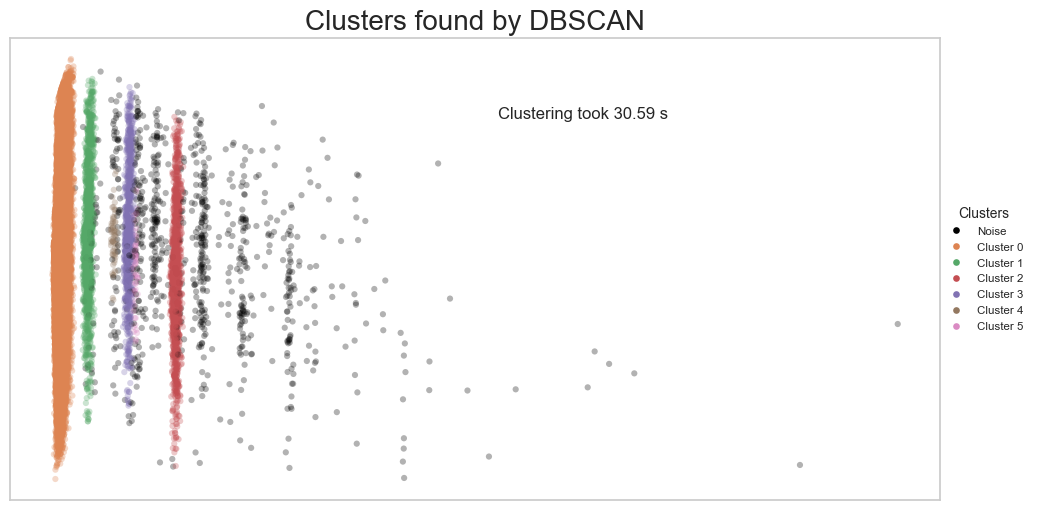

In [74]:
plot_clusters(X_transformed, DBSCAN, (), {"eps": 1, "min_samples": 43})

Number of clusters: 4
Number of noise points: 0
Le coefficient de silhouette : 0.3369147566502343
L'index de Davies-Bouldin : 1.0391893960990968


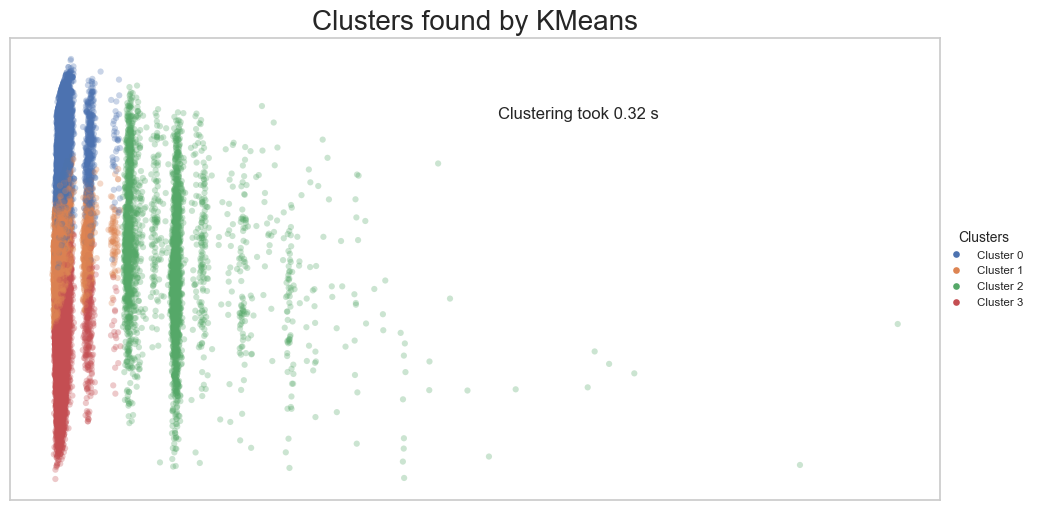

In [75]:
plot_clusters(
    X_transformed, KMeans, (), {"n_clusters": 4, "init": "k-means++", "n_init": "auto"}
)